# Cluster analyses Regression by Rohan adapted from Jenn's repo.

This code splits the df into windows of a specified length. 
The result is a list with each cell containing time_length X channels. 
The raw data contains 200ms of a prewindow and 1000ms of the test window.

In [2]:
import pandas as pd
import numpy as np
import setup_jwlab
from jwlab.constants import cleaned_data_filepath
from jwlab.cluster_analysis import prep_cluster_analysis, prep_raw_pred_avg
from jwlab.ml_prep import  average_trials_and_participants, average_trials
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from scipy import stats
from sklearn.svm import LinearSVC
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn import preprocessing
from scipy.stats import kurtosis, skew
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import more_itertools as mit
from regression.functions import get_w2v_embeds_from_dict, two_vs_two


In [3]:
length_per_window = 100 #just change this, do not alter the prep files
num_sliding_windows = int(1200/ length_per_window)

In [4]:
# all 9m 
participants = ["904"]#, "905", "906", "908", "909",  "910","912","913", "914", "916", "917", "919",\
#                 "920", "921",  "923","924", "927", "928", "929", "930", "932"]


In [ ]:
# #subset 9m
participants = ["904", "905", "906", "908", "909","910", "912", "913", "914",  "916", "917", "921", "923", "927", "929", "930", "932"] 
# removed: 919, 920, 924, 928


In [ ]:
participants = ["106", "107", "109", "111", "112", "115", "116", "117", "119",  "120", "121", "122", "124"]
# missing 105, 


In [ ]:
participants = ["106", "107", "109", "111", "112", "115", "116", "117", "119", "121", "122", "120", "124",\
               "904", "905", "906", "908", "910", "909", "912","913", "914", "916", "917", "919",\
                "920",  "923","921", "924", "927", "928", "929", "930", "932"]


# Trial count code

In [ ]:
#get trial counts
X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1200, averaging="no_averaging", length_per_window=length_per_window)


for i in participants:
    ps =[i]
    X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, ps, downsample_num=1000, averaging="no_averaging", length_per_window=length_per_window)
    y[0]
    np.amax(y[0])
    unique, counts = np.unique(y[0], return_counts=True)
    
    print(i)
    print(dict(zip(unique, counts)))

In [ ]:
print(cleaned_data_filepath)
X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1200, averaging="no_averaging", length_per_window=length_per_window)



## Train raw test avg

In [5]:

num_iter = 10

results = {}



for i in range(num_iter): 

    X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1000, averaging="no_average_labels", length_per_window=length_per_window)
    
    X_train, y_train, X_test, y_test, X_test_t, y_test_t, X_test_pt, y_test_pt = prep_raw_pred_avg(X, participants, length_per_window, num_sliding_windows)
#     print("y_train", y_train)
#     print("y_test", y_test)
#     print("y_test_t", y_test_t)
#     print("y_test_pt", y_test_pt)
    ## Now get a list of word embeddings from the labels.
#     y_train_labels = get_w2v_embeds_from_dict(y_train[0])
#     y_test_labels = get_w2v_embeds_from_dict(y_train[1])
#     y_test_t_labels = get_w2v_embeds_from_dict(y_test_t)
#     y_test_pt_labels = get_w2v_embeds_from_dict(y_test_pt)
#     print(y_train_labels)
#     print(y_test_labels)
#     break
    
    model = Ridge()
    #model = SVC(gamma=.001, kernel = 'rbf', C = 100)


    for j in range(num_sliding_windows):
        
        y_train_labels = get_w2v_embeds_from_dict(y_train[j])
        y_test_labels = get_w2v_embeds_from_dict(y_test[j])
        y_test_t_labels = get_w2v_embeds_from_dict(y_test_t[j])
        y_test_pt_labels = get_w2v_embeds_from_dict(y_test_pt[j])
        
        model.fit(X_train[j], y_train_labels)

        ## validation, predict raw
        y_pred = model.predict(X_test[j])
        points, total_points, testScore = two_vs_two(y_test_labels, y_pred)
#         print(testScore)
#         break

        ## predict averaged across trials
#         y_pred = model.predict(X_test_t[j])
#         testScore = two_vs_two(y_test_t[j],y_pred)

#         ## predict averaged across trials and ps
#         y_pred = model.predict(X_test_pt[j])
#         testScore = two_vs_two(y_test_pt[j],y_pred)


        if j in results.keys(): 
            results[j].append(testScore)
        else:
            results[j]=[]
            results[j].append(testScore)
    print(i)




0
1
2
3
4
5
6
7
8
9


In [7]:
# results

In [ ]:
unique, counts = np.unique(y_train[0], return_counts=True)
dict(zip(unique, counts))

In [8]:
scoreMean = []
sem = []

for i in range(num_sliding_windows):
    scoreMean.append(np.mean(results[i]))
    sem.append(round(stats.sem(results[i]), 2))
    #stdev.append(np.std(results[i]))

print(np.mean(scoreMean))
print(scoreMean)
print(sem)

0.537962962962963
[0.4333333333333333, 0.4222222222222222, 0.6888888888888889, 0.6222222222222222, 0.5555555555555556, 0.4888888888888888, 0.6111111111111112, 0.5333333333333333, 0.6222222222222222, 0.5444444444444445, 0.4444444444444445, 0.4888888888888888]
[0.06, 0.06, 0.07, 0.06, 0.05, 0.07, 0.05, 0.05, 0.06, 0.05, 0.04, 0.06]


ValueError: x and y must have same first dimension, but have shapes (13,) and (12,)

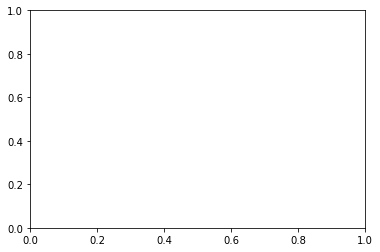

In [10]:
#plot results:

x_graph = np.arange(-200,1000,length_per_window)
y_graph = scoreMean
sem = np.array(sem)
error = sem
plt.plot(x_graph, y_graph, 'k-')
plt.fill_between(x_graph, y_graph-error, y_graph+error)
plt.show()

### Get t-mass

In [ ]:
stats.ttest_1samp(results[i], .5)

In [ ]:
clusters

In [ ]:
pvalues = []
tvalues = []
for i in range(len(results)):
    # change the second argument below for comparison
    istat = stats.ttest_1samp(results[i], .5)
    pvalues += [istat.pvalue] if istat.statistic > 0 else [1]
    tvalues += [istat.statistic] if istat.statistic > 0 else [0]

valid_window = [i for i,v in enumerate(pvalues) if v <= 0.025]
print("Valid windows are: {0}\n".format(valid_window))

# Obtain clusters (3 or more consecutive meaningful time)
clusters = [list(group) for group in mit.consecutive_groups(valid_window)]
clusters = [group for group in clusters if len(group) >= 3]

adj_clusters = []
for c in clusters: 
    new_list = [((x*10)-200) for x in c]
    adj_clusters.append(new_list)
print("Clusters are: {0}\n".format(adj_clusters))

t_mass = [0]
for c in clusters:
    t_scores = 0
    for time in c:
        t_scores += tvalues[time]
    t_mass += [t_scores]

max_t_mass = max(t_mass)
print("The max t mass is: {0}\n".format(max_t_mass))

## Null distribution

In [ ]:

num_iter = 10

results = {}


for i in range(num_iter): 

    X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1000, averaging="no_average_labels", length_per_window=length_per_window)
    #remap x labels
    
    
    X_train, y_train, X_test, y_test, X_test_t, y_test_t, X_test_pt, y_test_pt = prep_raw_pred_avg(X, participants, length_per_window, num_sliding_windows)

    
    model = LinearSVC(C=1e-9, max_iter=1000)
    #model = SVC(gamma=.001, kernel = 'rbf', C = 100)


    for j in range(num_sliding_windows):

            model.fit(X_train[j], y_train[j])

            # validation, predict raw
    #         y_pred = model.predict(X_train[j])
    #         testScore = accuracy_score(y_train[j],y_pred)

            # predict averaged across trials
#             y_pred = model.predict(X_test_t[j])
#             testScore = accuracy_score(y_test_t[j],y_pred)

            # predict averaged across trials and ps
            y_pred = model.predict(X_test_pt[j])
            testScore = accuracy_score(y_test_pt[j],y_pred)


            if j in results.keys(): 
                results[j].append(testScore)
            else:
                results[j]=[]
                results[j].append(testScore)
                
    print(i)

pvalues = []
for i in range(len(results)):
    # change the second argument below for comparison
    istat = stats.ttest_1samp(results[i], .5)
    pvalues += [istat.pvalue] if istat.statistic > 0 else [1]

valid_window = [i for i,v in enumerate(pvalues) if v <= 0.025]
print("Valid windows are: {0}\n".format(valid_window))

# Obtain clusters (3 or more consecutive meaningful time)
clusters = [list(group) for group in mit.consecutive_groups(valid_window)]
clusters = [group for group in clusters if len(group) >= 3]

adj_clusters = []
for c in clusters: 
    new_list = [((x*10)-200) for x in c]
    adj_clusters.append(new_list)
print("Clusters are: {0}\n".format(adj_clusters))

t_mass = []
for c in clusters:
    t_scores = 0
    for time in c:
        t_scores += pvalues[time]
    t_mass += [t_scores]

max_t_mass = max(t_mass)
print("The max t mass is: {0}\n".format(max_t_mass))



## Cross validation
For raw data

In [ ]:
# Randomized order of cross val, for raw data matrix

X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1200, averaging="no_averaging", length_per_window=length_per_window)


num_iterations = 5
num_folds = 5

results = {}
for i in range(num_iterations):
    for j in range(num_sliding_windows):
        Xfirst = X[j]
        yfirst = y[j]
        Xfirst['label'] = yfirst
        Xfirst = Xfirst.sample(frac=1).reset_index(drop=True) #randomization
        ys = Xfirst['label']
        Xs = Xfirst.drop(columns=['label'])
        
        #model = SVC(gamma=.001, kernel = 'rbf', C=1)
        model = LinearSVC(C=1, max_iter=5000)
        cv_results = cross_validate(model, Xs, ys, cv=num_folds)
        if j in results.keys(): 
            results[j] += cv_results['test_score'].tolist()
        else:
            results[j] = cv_results['test_score'].tolist()
    print(i)

    
for i in range(num_sliding_windows):
    assert len(results[i]) == num_iterations * num_folds


In [ ]:
X[0].shape
X.shape

## Cross validation
For averaged data

In [ ]:
# Cross validation with RepeatedKFold for averaged matrices

#Xwin, ywin, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1000, averaging="average_trials", length_per_window=length_per_window)
#Xwin, ywin, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1000, averaging="average_trials_and_participants", length_per_window=length_per_window)


num_iterations = 3
num_folds = 5


import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score



results = {}
for j in range(num_sliding_windows):
    X = Xwin[j]
    y = ywin[j]

    #model = SVC(gamma=.001, kernel = 'rbf', C=1e-4)
    model = LinearSVC(C=1, max_iter=5000)
    rkf = RepeatedKFold(n_splits=num_folds, n_repeats=num_iterations, random_state=2652124)
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        testScore = accuracy_score(y_test,y_pred)

        if j in results.keys(): 
            results[j].append(testScore)
        else:
            results[j]=[]
            results[j].append(testScore)
    

for i in range(num_sliding_windows):
    assert len(results[i]) == num_iterations * num_folds

In [ ]:
scoreMean = []
stdev = []

for i in range(num_sliding_windows):
    scoreMean.append(np.mean(results[i]))
    stdev.append(np.std(results[i]))

print( np.mean(scoreMean))
print(scoreMean)
print(stdev)

In [ ]:
# T-test
accuracy_by_guessing = [0.5] * (num_iterations * num_folds)
pvalues = []
for i in range(num_sliding_windows):
    istat = stats.ttest_1samp(results[i], .5)
    pvalues += [istat.pvalue] if istat.statistic > 0 else [1]

In [ ]:
# Finding contiguous time cluster
valid_window = [i for i,v in enumerate(pvalues) if v <= 0.025]
print(valid_window)

# Feature Extraction

In [ ]:
# X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1200, averaging="no_averaging", length_per_window=length_per_window)



In [ ]:
#X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1000, averaging="average_trials", length_per_window=length_per_window)
X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1000, averaging="average_trials_and_participants", length_per_window=length_per_window)



for k in range(len(X)):
    X[k] = pd.DataFrame(data=X[k][0:,0:])

In [ ]:
#Normalization 


#funcs = [np.mean, np.min, np.max, np.var, skew, kurtosis]
funcs = [np.mean, np.min, np.max, np.var]

df_feats_list = []

for j in range(num_sliding_windows):  
    df_feats = X[j].apply(funcs, axis=1)
    
    # calc skew
    skew_j = skew(X[j], axis = 1)
    df_feats['skew'] = skew_j

    # calc kurtosis
    kurt_j = kurtosis(X[j], axis = 1)
    df_feats['kurtosis'] = kurt_j


    
    #normalize: (x-xmin)/(max-min)

    # Get column names first
    names = df_feats.columns

    normalized_df = []
    for i in names: 
        x_array = np.array(df_feats[i])
        normalized_X = preprocessing.normalize([x_array])
        normalized_df.append(normalized_X)
    
    
    df_1 = pd.DataFrame(np.concatenate(normalized_df))
    df = df_1.T #transpose
    df.columns= ['mean', 'amin', 'amax', 'var', 'skew', 'kurtosis']

    

    #put all windows together into a list
    df_feats_list.append(df)
    
    




In [ ]:
# # Standarization: 

# #funcs = [np.mean, np.min, np.max, np.var, skew, kurtosis]
# funcs = [np.mean, np.min, np.max, np.var]

# df_feats_list = []

# for j in range(num_sliding_windows):  
#     df_feats = X[j].apply(funcs, axis=1)
    
#     # calc skew
#     skew_j = skew(X[j], axis = 1)
#     df_feats['skew'] = skew_j

#     # calc kurtosis
#     kurt_j = kurtosis(X[j], axis = 1)
#     df_feats['kurtosis'] = kurt_j


#     #standarized: (x-mean)/(stdev)

#      # Get column names first
#     names = df_feats.columns

#     # Create the Scaler object
#     scaler = preprocessing.StandardScaler()
#     # Fit your data on the scaler object
#     scaled_df = scaler.fit_transform(df_feats)
#     scaled_df = pd.DataFrame(scaled_df, columns=names)

#     #put all windows together into a list
#     df_feats_list.append(scaled_df)



# Cross val on extracted features

In [ ]:

num_iterations = 5
num_folds = 5

results = {}
for i in range(num_iterations):
    for j in range(num_sliding_windows):
        Xfirst = df_feats_list[j]
        yfirst = y[j]
        Xfirst['label'] = yfirst
        Xfirst = Xfirst.sample(frac=1).reset_index(drop=True) #randomization
        ys = Xfirst['label']
        Xs = Xfirst.drop(columns=['label'])
        
        #model = SVC(gamma=.001, kernel = 'rbf', C=100)
        model = LinearSVC(C=1e-3, max_iter=1000)
        cv_results = cross_validate(model, Xs, ys, cv=num_folds)
        if j in results.keys(): 
            results[j] += cv_results['test_score'].tolist()
        else:
            results[j] = cv_results['test_score'].tolist()
    print(i)

    
for i in range(num_sliding_windows):
    assert len(results[i]) == num_iterations * num_folds

In [ ]:
scoreMean = []
stdev = []

for i in range(num_sliding_windows):
    scoreMean.append(np.mean(results[i]))
    stdev.append(np.std(results[i]))



In [ ]:
scoreMean

In [ ]:
max(scoreMean)

In [ ]:
stdev

In [ ]:
# T-test
accuracy_by_guessing = [0.5] * (num_iterations * num_folds)
pvalues = []
for i in range(num_sliding_windows):
    istat = stats.ttest_1samp(results[i], .5)
    pvalues += [istat.pvalue] if istat.statistic > 0 else [1]

In [ ]:
# Finding contiguous time cluster
valid_window = [i for i,v in enumerate(pvalues) if v <= 0.025]
print(valid_window)

In [ ]:
#plot results:

x_graph = np.arange(-200,1000,length_per_window)
y_graph = scoreMean
stdev = np.array(stdev)
error = stdev
plt.plot(x_graph, y_graph, 'k-')
plt.fill_between(x_graph, y_graph-error, y_graph+error)
plt.show()